In [1]:
# Imports

import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
#from keras import backend as K
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.utils import plot_model

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import Concatenate, Dropout, LSTM, TimeDistributed, Dense, BatchNormalization, Bidirectional, Lambda, SpatialDropout1D

import pickle
import h5py

In [2]:
def read_data():
    #os.chdir('D:/TU_Graz/Thesis/Datasets/Reddit_features')
    train = pd.read_csv("../input/bio-tagged/train_final_all.csv") #train = pd.read_csv("train_final_all.csv")
    test = pd.read_csv("../input/bio-tagged/test_final_all.csv") #test = pd.read_csv("test_final_all.csv")
    data = train.append(test)
    return train, test, data

def create_lists(data_df, word_category, class_category):
    words = list(set(data_df[word_category].values))
    words.append("ENDPAD")
    n_words = len(words)
    tags = list(set(data_df[class_category].values))
    n_tags = len(tags)
    return words, n_words, tags, n_tags

In [3]:
def group_sentences(data, sent_identificator, category):
    all_sents = []
    sent_ids = data[sent_identificator].unique()
    for curr_id in sent_ids:
        tmp_df = data[data[sent_identificator] == curr_id]
        tmp_df = pd.concat([tmp_df['Sent_id'], tmp_df['Token'], tmp_df["Token_index"], tmp_df.iloc[:,4:44], tmp_df.iloc[:,137:147], tmp_df[category]], axis = 1) 
        records = tmp_df.to_records(index=False)
        all_sents.append(records)
        
    return all_sents


def remove_sents_over_threshold(sents, threshold):
    sentences = list()
    for s in sents:
        if len(s) < threshold:
            sentences.append(s)
    return sentences

In [5]:
def prepare_and_pad(sentences, max_len, tag2idx):
    X1 = [[w[1] for w in s] for s in sentences]
    new_X = []
    for seq in X1:
        new_seq = []
        for i in range(max_len):
            try:
                new_seq.append(seq[i])
            except:
                new_seq.append("__PAD__")
        new_X.append(new_seq)
    X1 = new_X
    
    X2 = []
    for sentence in sentences:
        sent_ft = list()
        for word in sentence:
            ft = [word[i] for i in range(2, 52)]
            sent_ft.append(ft)
        for j in range(len(sentence)-1, max_len-1):
            ft = [0] * 50
            sent_ft.append(ft)
        X2.append(sent_ft)  
        
    y = [[tag2idx[w[len(w)-1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
    
    return X1, X2, y

In [6]:
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),
                              "sequence_len": tf.constant(batch_size*[max_len])},
                      signature="tokens",
                      as_dict=True)["elmo"]

In [7]:
def build_model(max_len, n_words, n_tags): 
    word_input_layer = Input(shape=(max_len, 50, ))
    elmo_input_layer = Input(shape=(max_len,), dtype=tf.string)
    
    word_output_layer = Dense(50, activation = 'softmax')(word_input_layer)
    elmo_output_layer = Lambda(ElmoEmbedding, output_shape=(None, 1024))(elmo_input_layer)
    
    output_layer = Concatenate()([word_output_layer, elmo_output_layer])
    output_layer = SpatialDropout1D(0.1)(elmo_output_layer)
    output_layer = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.35))(output_layer)
    output_layer = TimeDistributed(Dense(n_tags, activation='softmax'))(output_layer)
    model = Model([elmo_input_layer, word_input_layer], output_layer)
    
    return model

In [8]:
def plot_learning_curves(curve1, curve2):
    plt.figure(figsize=(6,6))
    plt.plot(curve1)
    plt.plot(curve2)
    plt.show()

Loading the data...
Creating sets of words and tags...
Creating sentence list...
Creating word and tag maps...
Preparing and padding training data...
Splitting data...
Setting parameters...


2022-10-10 09:58:56.696762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 09:58:56.854463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 09:58:56.855268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 09:58:56.856580: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Building the model...


2022-10-10 09:59:00.844323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 09:59:00.844927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 09:59:00.845290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 09:59:00.845739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 09:59:00.846094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (32, None, 1024)     0           input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (32, None, 1024)     0           lambda[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (32, None, 1024)     6295552     spatial_dropout1d[0][0]          
______________________________________________________________________________________________

2022-10-10 09:59:07.457540: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


928/928 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.9290

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


928/928 [==============================] - 78s 84ms/sample - loss: 0.2902 - accuracy: 0.9290 - val_loss: 0.1055 - val_accuracy: 0.9712
Epoch 2/20
928/928 [==============================] - 69s 74ms/sample - loss: 0.0890 - accuracy: 0.9753 - val_loss: 0.0804 - val_accuracy: 0.9774
Epoch 3/20
928/928 [==============================] - 69s 74ms/sample - loss: 0.0710 - accuracy: 0.9801 - val_loss: 0.0697 - val_accuracy: 0.9802
Epoch 4/20
928/928 [==============================] - 69s 75ms/sample - loss: 0.0614 - accuracy: 0.9821 - val_loss: 0.0633 - val_accuracy: 0.9814
Epoch 5/20
928/928 [==============================] - 69s 74ms/sample - loss: 0.0550 - accuracy: 0.9836 - val_loss: 0.0597 - val_accuracy: 0.9822
Epoch 6/20
928/928 [==============================] - 68s 74ms/sample - loss: 0.0496 - accuracy: 0.9850 - val_loss: 0.0576 - val_accuracy: 0.9829
Epoch 7/20
928/928 [==============================] - 69s 74ms/sample - loss: 0.0456 - accuracy: 0.9860 - val_loss: 0.0556 - val_accura

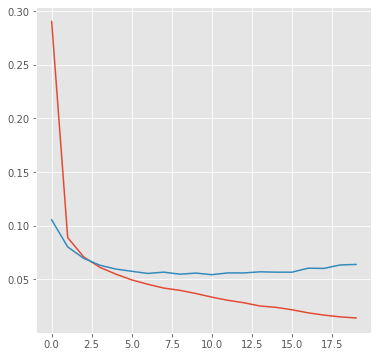

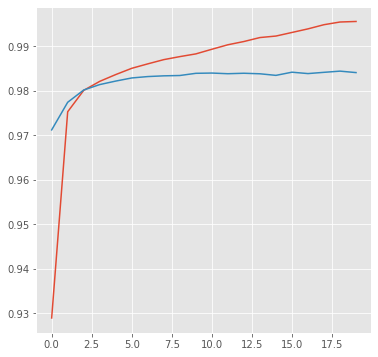

In [9]:
max_len = 300
batch_size = 32
#batch_size = 2

plt.style.use("ggplot")

print("Loading the data...")
train, test, data = read_data()

################################## TRAIN ################################

print("Creating sets of words and tags...")
words, n_words, tags, n_tags = create_lists(train, "Token", "BIO")

print("Creating sentence list...")
sents = group_sentences(train, "Sent_id", "BIO")
sentences = [s for s in sents if len(s) < max_len]

print("Creating word and tag maps...")
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in tag2idx.items()}

print("Preparing and padding training data...")
X1, X2, y = prepare_and_pad(sentences, max_len, tag2idx)

print("Splitting data...")
X1_train, X1_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=2021)
X2_train, X2_valid, y_train, y_valid = train_test_split(X2, y, test_size=0.2, random_state=2021)
X1_train = X1_train[:(len(X1_train) // batch_size) * batch_size]
X2_train = X2_train[:(len(X2_train) // batch_size) * batch_size]
X1_valid = X1_valid[:(len(X1_valid) // batch_size) * batch_size]
X2_valid = X2_valid[:(len(X2_valid) // batch_size) * batch_size]

y_train = y_train[:(len(y_train) // batch_size) * batch_size]
y_valid = y_valid[:(len(y_valid) // batch_size) * batch_size] 
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)
   
print("Setting parameters...")
tf.disable_eager_execution()
elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess = tf.Session()
K.set_session(sess)
sess.run([tf.global_variables_initializer(), tf.tables_initializer()])

print("Building the model...")
model = build_model(max_len, n_words, n_tags)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


history = model.fit([np.array(X1_train), np.array(X2_train).reshape((len(X2_train), max_len, 50))],
                    y_train,
                    validation_data=([np.array(X1_valid), np.array(X2_valid).reshape((len(X2_valid), max_len, 50))], y_valid),
                    batch_size=batch_size, epochs=20, verbose=1)

hist = pd.DataFrame(history.history)

plot_learning_curves(hist["loss"], hist["val_loss"])
plot_learning_curves(hist["accuracy"], hist["val_accuracy"])

In [51]:
################# TEST ################################

print("Creating sentence list...")
sents_test = group_sentences(test, "Sent_id", "BIO")
sentences_test = [s[:300] for s in sents_test]

print("Preparing and padding training data...")
X1_test, X2_test, y_test = prepare_and_pad(sentences_test, max_len, tag2idx)

for i in range(0, 25):
    X1_test.append(X1_test[0])
    X2_test.append(X2_test[0])
    y_test = np.append(y_test,[y_test[0]], axis=0)
    
y_pred = model.predict([np.array(X1_test), np.array(X2_test).reshape((len(X2_test), max_len, 50))])

Creating sentence list...
Preparing and padding training data...


In [52]:
p = np.argmax(y_pred, axis=-1)

y_orig = []
for sent in y_test:
    for tag in sent:
        y_orig.append(tag)
y_preds = []
for sent in p:
    for tag in sent:
        y_preds.append(tag)
        
report = classification_report(y_orig, y_preds)
print(report) 

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1680
           1       0.64      0.33      0.44       700
           2       0.57      0.67      0.62        30
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        29
           6       0.92      0.88      0.90      1336
           7       0.56      0.39      0.46        23
           8       0.47      0.24      0.32       488
           9       0.00      0.00      0.00         4
          10       0.96      0.84      0.90       194
          11       0.26      0.14      0.18        42
          12       0.81      0.84      0.82       257
          13       0.83      0.28      0.42        18
          15       0.99      1.00      0.99     91149
          16       0.58      0.58      0.58        26

    accuracy                           0.98     96000
   macro avg       0.53   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
i = 5
#p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X1_test[i], y_test[i], p[i]):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
Looking        :O     (O)
for            :O     (O)
slow           :B-keyword-pos (B-keyword-pos)
burning        :I-keyword-pos (I-keyword-pos)
,              :O     (O)
violent        :B-keyword-pos (B-keyword-pos)
films          :O     (O)
Slower         :O     (O)
movies         :O     (O)
with           :O     (O)
tense          :B-keyword-pos (B-keyword-pos)
dialogue       :I-keyword-pos (I-keyword-pos)
,              :O     (O)
either         :O     (O)
very           :O     (O)
close          :O     (O)
up             :O     (O)
or             :O     (O)
super          :O     (O)
wide           :O     (O)
shots          :O     (O)
all            :O     (O)
culminating    :O     (O)
with           :O     (O)
some           :O     (O)
brutal         :O     (B-keyword-pos)
violence       :O     (I-keyword-pos)
.              :O     (O)
Movies         :O     (O)
like           :O     (O)
this           :O     (O)
include        :O     (O)
:             

In [54]:
from difflib import SequenceMatcher

def create_alt_movie_dict(movies_matched):
    alt_names = dict()
    for index, row in movies_matched.iterrows():
        if row["original_title"] not in alt_names.keys():
            alt_names[row["original_title"]] = list()
        alt_names[row["original_title"]].append(row["alternative"])
    return alt_names

# Turn the predictions from numerical to their class names

predictions = []
for sent in p:
    sent_categories = []
    for num in sent:
        sent_categories.append(idx2tag[num])
    predictions.append(sent_categories)

In [56]:
model_name = 'elmo_features'
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_name + ".h5")

dict_save = open("t2idx_efeats.json", "w")
json.dump(tag2idx, dict_save)
dict_save.close()

dict_save = open("idx2t_efeats.json", "w")
json.dump(idx2tag, dict_save)
dict_save.close()

In [59]:
all_outputs = dict()   # Stores all outputs from the test dataset per entity
all_outputs_per_sentence = dict()  # Stores separate dictionaries per entity for every sentence in the dataset

for i in range(0, len(predictions)): # Sentences iteration
    tmp_dict = dict()
    for j in range(0, len(predictions[i])-2): # Word iteration
        if predictions[i][j] == 'B-movie-pos':
            if not 'positive_movies' in all_outputs.keys():
                all_outputs['positive_movies'] = []
            if not 'positive_movies' in tmp_dict.keys():
                tmp_dict['positive_movies'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-movie-pos' and k < max_len-1):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['positive_movies'].append(tmp_entity)
            if tmp_entity not in tmp_dict['positive_movies']:
                tmp_dict['positive_movies'].append(tmp_entity)
        
        if predictions[i][j] == 'B-movie-neg':
            if not 'negative_movies' in all_outputs.keys():
                all_outputs['negative_movies'] = []
            if not 'negative_movies' in tmp_dict.keys():
                tmp_dict['negative_movies'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-movie-neg'):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['negative_movies'].append(tmp_entity)
            if tmp_entity not in tmp_dict['negative_movies']:
                tmp_dict['negative_movies'].append(tmp_entity)
            
        if predictions[i][j] == 'B-keyword-pos':
            if not 'positive_keywords' in all_outputs.keys():
                all_outputs['positive_keywords'] = []
            if not 'positive_keywords' in tmp_dict.keys():
                tmp_dict['positive_keywords'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-keyword-pos'):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['positive_keywords'].append(tmp_entity)
            if tmp_entity not in tmp_dict['positive_keywords']:
                tmp_dict['positive_keywords'].append(tmp_entity)
            
        if predictions[i][j] == 'B-keyword-neg':
            if not 'negative_keywords' in all_outputs.keys():
                all_outputs['negative_keywords'] = []
            if not 'negative_keywords' in tmp_dict.keys():
                tmp_dict['negative_keywords'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-keyword-neg'):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['negative_keywords'].append(tmp_entity)
            if tmp_entity not in tmp_dict['negative_keywords']:
                tmp_dict['negative_keywords'].append(tmp_entity)
            
        if predictions[i][j] == 'B-actor-pos':
            if not 'positive_actors' in all_outputs.keys():
                all_outputs['positive_actors'] = []
            if not 'positive_actors' in tmp_dict.keys():
                tmp_dict['positive_actors'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-actor-pos'):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['positive_actors'].append(tmp_entity)
            if tmp_entity not in tmp_dict['positive_actors']:
                tmp_dict['positive_actors'].append(tmp_entity)
            
        if predictions[i][j] == 'B-actor-neg':
            if not 'negative_actors' in all_outputs.keys():
                all_outputs['negative_actors'] = []
            if not 'negative_actors' in tmp_dict.keys():
                tmp_dict['negative_actors'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-actor-neg'):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['negative_actors'].append(tmp_entity)
            if tmp_entity not in tmp_dict['negative_actors']:
                tmp_dict['negative_actors'].append(tmp_entity)
            
        if predictions[i][j] == 'B-gen-pos':
            if not 'positive_genres' in all_outputs.keys():
                all_outputs['positive_genres'] = []
            if not 'positive_genres' in tmp_dict.keys():
                tmp_dict['positive_genres'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-gen-pos'):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['positive_genres'].append(tmp_entity)
            if tmp_entity not in tmp_dict['positive_genres']:
                tmp_dict['positive_genres'].append(tmp_entity)
            
        if predictions[i][j] == 'B-gen-neg':
            if not 'negative_genres' in all_outputs.keys():
                all_outputs['negative_genres'] = []
            if not 'negative_genres' in tmp_dict.keys():
                tmp_dict['negative_genres'] = []
            tmp_entity = X1_test[i][j]
            k = j+1
            while(predictions[i][k] == 'I-gen-neg'):
                tmp_entity += ' ' + X1_test[i][k]
                k +=1 
            all_outputs['negative_genres'].append(tmp_entity)
            if tmp_entity not in tmp_dict['negative_genres']:
                tmp_dict['negative_genres'].append(tmp_entity)
    
    #print(sentences_test[i][0][0])
    #print(tmp_dict)
    if i < len(sentences_test):
        all_outputs_per_sentence[sentences_test[i][0][0]] = tmp_dict
    #print(tmp_movie)

In [60]:
with open("elmo_feats.json", "w") as outfile:
    json.dump(all_outputs_per_sentence, outfile)

In [61]:
all_outputs_per_sentence['5ixah2']

{'positive_keywords': ['boring', 'artsy', 'goofy', 'anime'],
 'positive_movies': ['Antichrist',
  'The Lobster',
  'Swiss Army Man',
  'Shaun of the Dead',
  'Tucker',
  'Dale VS Evil',
  'The Pianist',
  'The Green Room',
  'Gurren Lagann',
  'Parasyte'],
 'positive_genres': ['horror', 'war', 'action'],
 'positive_actors': ['Hayao Miyazaki']}